#**Задача 3.4**
[Даны результаты работы двух машинных переводчиков на небольших выборках переводов для разных языковых пар](https://github.com/andriygav/PSAD/tree/master/labs/lab1/data/mt).

Стандартная оценка качества перевода производится с использованием специальной метрики [BLEU](https://en.wikipedia.org/wiki/BLEU). Реализовано [здесь](https://www.nltk.org/_modules/nltk/translate/bleu_score.html).

Требуется опеделить:
*   превосходит ли один переводчик в среднем по парам второй переводчик по переводу
*   связано ли качество перевода для разных языковых пар для двух переводчиков?

При подсчете BLEU учитывать только слова, регистр не учитывать.

**Формат данных**

Название файлов имеет формат lang1_lang2_\<translator_id\>.txt:
*   lang_1, lang_2 --- языки (перевод с lang_1 на lang_2).
*   gold --- эталонный вариант, с которым сравнивается перевод от систем машинного перевода.



---

#Решение

In [ ]:
!pip install permute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import numpy.random
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from permute.core import one_sample

In [ ]:
# параметр для задания толщины линии
plt.rcParams['lines.linewidth'] = 1
# параметр для задания ширины точек
plt.rcParams['lines.markersize'] = 6
# параметр для задания шрифта осей x и y (цифр на осях)
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
# параметр для задания шрифта на осях 
plt.rcParams['legend.fontsize'] = 12
# параметр для задания шрифта заголовка
plt.rcParams['axes.titlesize'] = 32
# параметр для задания шрифта осей x и y (название оси)
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['figure.figsize'] = (8.0, 6.0)
# параметр для задания шрифта вспомагательных записей на графику (annotate или text)
plt.rcParams['font.size'] = 13

Получаем данные

In [ ]:
langs = ['de_en_', 'en_kk_', 'en_ru_', 'ru_de_', 'ru_kk_']
vars = ['1', '2', 'gold', 'orig']
part_path = 'https://github.com/andriygav/PSAD/tree/master/labs/lab1/data/mt/'
!mkdir mt/
for lang in langs:
  for var in vars:
    path = part_path + lang + var + '.txt'
    end_path = 'mt/' + lang + var + '.txt'
    !wget {path} -O {end_path}

--2023-05-23 03:28:51--  https://github.com/andriygav/PSAD/tree/master/labs/lab1/data/mt/de_en_1.txt
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/andriygav/PSAD/blob/master/labs/lab1/data/mt/de_en_1.txt [following]
--2023-05-23 03:28:51--  https://github.com/andriygav/PSAD/blob/master/labs/lab1/data/mt/de_en_1.txt
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘mt/de_en_1.txt’

mt/de_en_1.txt          [ <=>                ] 176.57K  --.-KB/s    in 0.02s   

2023-05-23 03:28:52 (7.15 MB/s) - ‘mt/de_en_1.txt’ saved [180810]

--2023-05-23 03:28:52--  https://github.com/andriygav/PSAD/tree/master/labs/lab1/data/mt/de_en_2.txt
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443.

##Предобработка текста
Уберем влияние регистра и знаков препинания

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.translate import bleu_score
import os
#import re

In [ ]:
def Processing(data):
  data = data.lower() # Приводим текст к нижнему регистру
  tokenizer = RegexpTokenizer(r'\w+') # Создаем tokenizer и устанавливаем шаблон для удаления знаков препинания
  tokens = tokenizer.tokenize(data)
  return tokens

In [ ]:
!pip install nltk==3.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434677 sha256=62013c034467d1d84bbe8d8c47d45e3b1505bd3abbec7ad49c7fe0bc230987ae
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1


In [ ]:
from nltk.sem.logic import VariableExpression
bleu_1 = []
bleu_2 = []
for tr in np.arange(2):
  for lang in langs:
    tr_name = 'mt/' + lang + str(tr+1) + '.txt'
    gold_name = 'mt/' + lang + 'gold' + '.txt'

    with open(tr_name, 'r', encoding='utf-8') as f:
            translation = f.read().strip()
    with open(gold_name, 'r', encoding='utf-8') as f:
            gold = f.read().strip()
    translation = Processing(translation)
    gold = Processing(gold)
    bleu_score_res = bleu_score.sentence_bleu([gold], translation)
    if tr + 1 == 1:
      bleu_1.append(bleu_score_res) 
    else:
      bleu_2.append(bleu_score_res)
print('bleu_1 = ', bleu_1)
print('bleu_2 = ', bleu_2)

bleu_1 =  [0.9574325619732018, 0.9728653052801091, 0.9604348292200747, 0.9713100790594006, 0.9555307136161584]
bleu_2 =  [0.9582525670946617, 0.9736623170392441, 0.9610778254226923, 0.9713793432766068, 0.9633521759296882]


Получили две связанные выборки $X_1, X_2$.

In [ ]:
print('X_1_mean = ', np.array(bleu_1).mean())
print('X_2_mean = ', np.array(bleu_2).mean())

X_1_mean =  0.9635146978297889
X_2_mean =  0.9655448457525786


Делаем предположение, что качество второго переводчика лучше, т.к. $\forall i: X_{2i} > X_{1i}$ (соответственно и $\overline{X}_2 > \overline{X}_1$). В данном случае по значениям выборок видно, что нет необходимости проверять выборки на нормальность. Для нашего предположения воспользуемся перестановочным критерием против левосторонней альтернативы:
\begin{align*}
& X_1^n, X_2^n \text{ - связанные}\\
& \text{распределение попарных разностей симметрично};\\
& H_0: \mathbb{E}(X_1 - X_2) = 0  \\
& H_1: \mathbb{E}(X_1 - X_2) < 0\\
& T(X_1^n, X_2^n) = \sum\limits_{i=1}^n ( X_{1i} - X_{2i} )  \\
\text{нулевое распределение: } & \text{порождается перебором знаков перед слагаемыми}
\end{align*}

In [ ]:
p_value, statistics = one_sample(np.array(bleu_1) - np.array(bleu_2), alternative='less')
print('p-value =', p_value, '< 0.05')

p-value = 0.03089969100308997 < 0.05


Гипотеза о равенстве мат.ожидания выборок отклоняется в пользу левосторонней альтернативы. Делаем вывод о том, что второй переводчик в среднем по парам лучше первого

##Применим методы дисперсионного анализа


In [ ]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.formula.api import ols

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

Создаем датафрейм

In [ ]:
data = pd.DataFrame(({'bleu_score': bleu_1 + bleu_2, 'translator': ['1']*5 + ['2']*5, 'lang': langs + langs}))
data.head(10)

,bleu_score,translator,lang
0,0.957433,1,de_en_
1,0.972865,1,en_kk_
2,0.960435,1,en_ru_
3,0.971310,1,ru_de_
4,0.955531,1,ru_kk_
5,0.958253,2,de_en_
6,0.973662,2,en_kk_
7,0.961078,2,en_ru_
8,0.971379,2,ru_de_
9,0.963352,2,ru_kk_


У нас тут два фактора - переводчик и язык, поэтому для начала проверим двухфакторным анализом

In [ ]:
lm = ols('bleu_score ~ C(translator) * C(lang)',data=data).fit()
table = sm.stats.anova_lm(lm)
table

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/anova.py:138: RuntimeWarning: divide by zero encountered in double_scalars
  (model.ssr / model.df_resid))


,df,sum_sq,mean_sq,F,PR(>F)
C(translator),1.0,1.030375e-05,0.000010,0.0,NaN
C(lang),4.0,4.151511e-04,0.000104,0.0,NaN
C(translator):C(lang),4.0,2.114682e-05,0.000005,0.0,NaN
Residual,0.0,3.451266e-30,inf,NaN,NaN


Интересный вывод) 
Различий он не видит

In [ ]:
lm = ols('bleu_score ~ C(translator) + C(lang)',data=data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(translator),1.0,0.000010,0.000010,1.948993,0.235193
C(lang),4.0,0.000415,0.000104,19.631841,0.006820
Residual,4.0,0.000021,0.000005,NaN,NaN


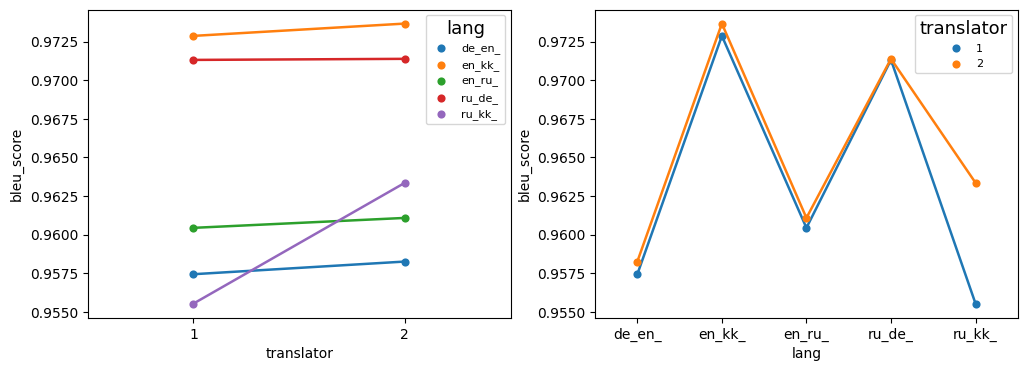

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['axes.titlesize'] = 16

plt.rcParams['axes.labelsize'] = 10
sns.pointplot(x="translator", y="bleu_score", data=data, hue='lang', ax = ax[0])
#ax2 = ax1.twinx()
sns.pointplot(x="lang", y="bleu_score", data=data, hue='translator', ax = ax[1])
# _ = sns.pointplot(x="translator", y="bleu_score", data=data, hue='lang')
plt.show()

Видно, что графики с разными переводчиками не пересекаются, а вот с языками - пересекаются, т.е. имеется влияние языка на качество перевода

Тут мы видим, что язык влияет на качество перевода, а вот гипотезу об отсутствии влияния качества перевода от типа переводчика мы отклонить не можем. Т.к. влияние переводчика не значимо, разделять выборку мы не будем

In [ ]:
mc = MultiComparison(data['bleu_score'], data['lang'])
result = mc.tukeyhsd()
 
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
de_en_ en_kk_   0.0154 0.0087  0.0054  0.0255   True
de_en_ en_ru_   0.0029  0.772 -0.0071   0.013  False
de_en_ ru_de_   0.0135 0.0154  0.0034  0.0236   True
de_en_ ru_kk_   0.0016 0.9619 -0.0085  0.0117  False
en_kk_ en_ru_  -0.0125 0.0212 -0.0226 -0.0024   True
en_kk_ ru_de_  -0.0019 0.9305  -0.012  0.0081  False
en_kk_ ru_kk_  -0.0138  0.014 -0.0239 -0.0038   True
en_ru_ ru_de_   0.0106 0.0412  0.0005  0.0206   True
en_ru_ ru_kk_  -0.0013 0.9808 -0.0114  0.0087  False
ru_de_ ru_kk_  -0.0119  0.026  -0.022 -0.0018   True
----------------------------------------------------


Здесь мы можем посмотреть, какие тексты переводчики переводили лучше. Сравнение выполнено попарно